In [2]:
!pip install lightgbm

In [3]:
!git clone https://github.com/Keshfer/Chocolate-Rating-ML

Cloning into 'Chocolate-Rating-ML'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 210 (delta 112), reused 114 (delta 49), pack-reused 0 (from 0)
Receiving objects: 100% (210/210), 22.91 MiB | 17.19 MiB/s, done.
Resolving deltas: 100% (112/112), done.
Updating files: 100% (39/39), done.


In [4]:
cd Chocolate-Rating-ML

/content/Chocolate-Rating-ML


In [5]:
# Import approriate functions and packages
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import the dataframe
df = pd.read_csv('cacao_engineered.csv')

# Create X and y training and testing data
X = df.drop(['Rating', 'Unnamed: 0'], axis=1)
y = df['Rating']

# Clean up columns of X so it works with the model
X.columns = [col.replace(" ", "_").replace(":", "_") for col in X.columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [6]:
# Start creating lgb regression model
# Create the lgb Dataset objects to store the training and testing data
train_data = lgb.Dataset(X_train, label = y_train)
test_data = lgb.Dataset(X_test, label = y_test, reference=train_data)

# Set parameters for the lgb regression model
# Objective: Set to regression so that the model tries to predict a regressive value (in this case, quality)
# Metric: The loss metric to be used for the model. Set to mse for now.
# Learning rate: How much to update the trees when refining
# Feature fraction: The percentage of features to take into account when making model, used to prevent overfitting
params = {
    'objective': 'regression',
    'metric': 'mse',
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'verbose':-1
}

# Train the actual model, passes in the parameters, training data, the number of rounds to train
num_round = 100  # Number of boosting rounds
model = lgb.train(
    params,
    train_data,
    num_boost_round=num_round,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'eval'],
)

# Predict on the test set, using the best iteration of the model for training
y_pred = model.predict(X_test, num_iteration = model.best_iteration)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")

MSE: 0.20545347525361096


In [7]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from lightgbm import LGBMRegressor
import math

# Create the model
model = LGBMRegressor()

# Parameter grid for grid search algorithm
param_grid = {
    'objective': ['regression'],
    'metric': ['mse'],
    'lambda_l2': [0.1],
    'feature_fraction': [0.8, 0.9, 1.0],
    'num_leaves': [20, 31, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [30, 50, 100],
    'max_depth': [-1, 10, 20]
}

# Grid search
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3
)

# Fit the grid search
grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LGBMRegressor(),
             param_grid={'feature_fraction': [0.8, 0.9, 1.0],
                         'lambda_l2': [0.1], 'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [-1, 10, 20], 'metric': ['mse'],
                         'n_estimators': [30, 50, 100],
                         'num_leaves': [20, 31, 40],
                         'objective': ['regression']})

In [8]:
# Print best parameters and score
print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

# Evaluate on test data
best_model = grid.best_estimator_
print(X.dtypes)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# Display the important metrics
print("Mean squared error:", mse)
print("Root mean squared error:", math.sqrt(mse))

# R^2 score
r2 = r2_score(y_test, y_pred)
adjusted_r2score = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
print("Adjusted R^2 score:", adjusted_r2score)

# MAE and MAPE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

mape = (abs((y_test - y_pred) / y_test).mean()) * 100
print("Mean Absolute Percentage Error:", mape, "%")

Best Parameters: {'feature_fraction': 1.0, 'lambda_l2': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'metric': 'mse', 'n_estimators': 100, 'num_leaves': 20, 'objective': 'regression'}
Best Score: 0.07456837277857713
REF                            int64
Review_Date                    int64
Cocoa_Percent                float64
Company_Location_AF          float64
Company_Location_AS          float64
Company_Location_CA          float64
Company_Location_CEU         float64
Company_Location_CR          float64
Company_Location_EEU         float64
Company_Location_NA          float64
Company_Location_OC          float64
Company_Location_SA          float64
Company_Location_WEU         float64
Broad_Bean_Origin_AF         float64
Broad_Bean_Origin_AS         float64
Broad_Bean_Origin_CA         float64
Broad_Bean_Origin_CR         float64
Broad_Bean_Origin_NA         float64
Broad_Bean_Origin_OC         float64
Broad_Bean_Origin_SA         float64
Broad_Bean_Origin_Unknown    float64
dtype: 

In [9]:
import joblib

joblib.dump(best_model, 'lightgbm_model.pkl')

# from google.colab import drive
# drive.mount('/content/drive')
# joblib.dump(model, '/content/drive/MyDrive/best_model.pkl')  # Save to your Google Drive

['lightgbm_model.pkl']

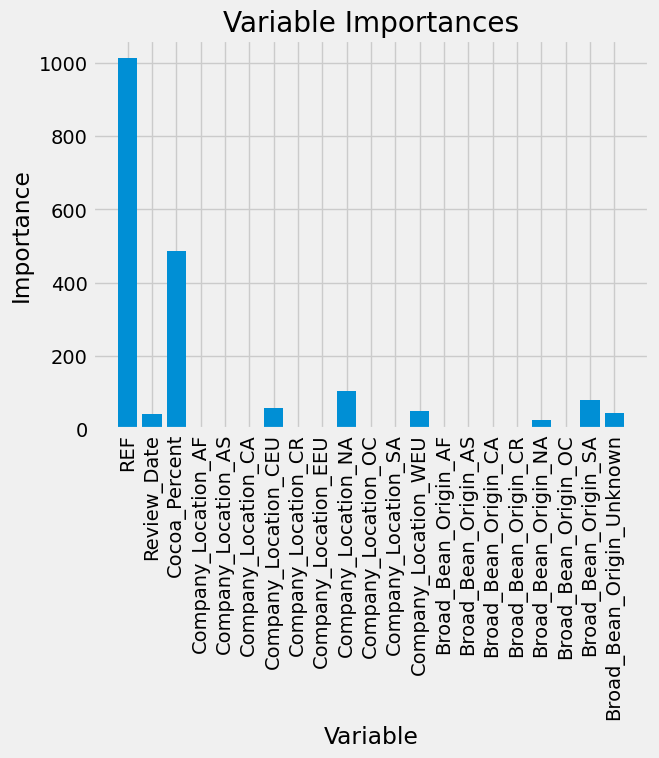

In [10]:
import matplotlib.pyplot as plt

importances = best_model.feature_importances_

plt.style.use('fivethirtyeight')# list of x locations for plotting
x_values = list(range(len(importances)))# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')# Tick labels for x axis
plt.xticks(x_values, best_model.feature_name_, rotation='vertical')# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

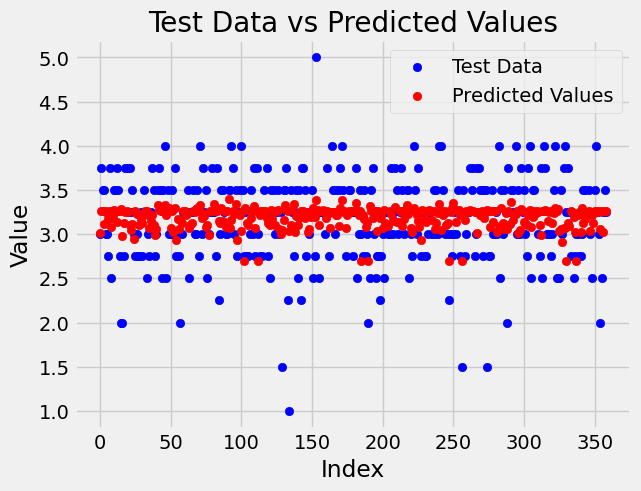

In [11]:
plt.scatter(range(len(y_test)), y_test, color='blue', label='Test Data')  # Actual test data
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Values')  # Predicted values

# Add labels and legend
plt.title('Test Data vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

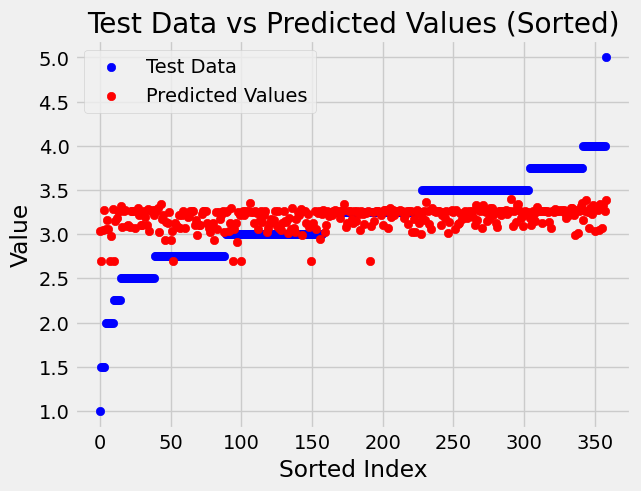

In [12]:
sorted_indices = np.argsort(y_test)  # Indices to sort y_test
y_test_sorted = np.array(y_test)[sorted_indices]  # Sorted y_test
y_pred_sorted = np.array(y_pred)[sorted_indices]  # Align y_pred with sorted y_test

# Create a scatter plot
plt.scatter(range(len(y_test_sorted)), y_test_sorted, color='blue', label='Test Data')  # Sorted actual values
plt.scatter(range(len(y_pred_sorted)), y_pred_sorted, color='red', label='Predicted Values')  # Sorted predictions

# Add labels and legend
plt.title('Test Data vs Predicted Values (Sorted)')
plt.xlabel('Sorted Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

In [14]:
# Do random search to further explore for potential optimal hyperparameters
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'feature_fraction': [0.6, 0.7, 0.8, 0.9, 1.0],
    'num_leaves': [20, 31, 50, 70],
    'min_data_in_leaf': [10, 20, 30, 50],
    'max_depth': [3, 5, 7, -1],  # -1 means no limit
}

model_random = LGBMRegressor()

random_search = RandomizedSearchCV(estimator=model_random, param_distributions=param_grid, n_iter=200, cv=5, error_score='raise', verbose=3, n_jobs=-1)
random_search.fit(X_train, y_train)
print('\n')
print(f"Best parameters from Random Search: {random_search.best_params_}")
model_random = random_search.best_estimator_
y_pred_rand = model_random.predict(X_test)

#evaluate model
mse_rand = mean_squared_error(y_test, y_pred_rand)
print("Mean Squared Error", mse_rand)

rmse_rand = mse_rand**0.5
print("Root Mean Squared Error", rmse_rand)

r2score = r2_score(y_test, y_pred_rand)
#adjusted rscore is just rscore but the rscore can increase with additional features even though no improvement occurs for model's performance.
#Basically adjusted negates the weakness of rscore
adjusted_r2score_rand = 1- ((1 - r2score) * ((df.shape[0] - 1) / (df.shape[0] - df.shape[1] - 1)))
print("Adjusted R Squared Score: ", adjusted_r2score_rand)

mae_rand = (1/ df.shape[0]) * sum(abs(y_test - y_pred_rand))
print(f"Mean Absolute Error: {mae_rand}")
errors = abs(y_test - y_pred_rand)
mape_rand = (1/len(y_test)) * sum(errors / y_test) * 100
print(f"Mean Absolute Percentage Error: {mape_rand}%")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


Best parameters from Random Search: {'num_leaves': 31, 'min_data_in_leaf': 10, 'max_depth': 3, 'learning_rate': 0.05, 'feature_fraction': 1.0}
Mean Squared Error 0.20845056138327775
Root Mean Squared Error 0.4565638634224984
Adjusted R Squared Score:  0.08654134363207822
Mean Absolute Error: 0.07026473545171433
Mean Absolute Percentage Error: 12.281808937987131%


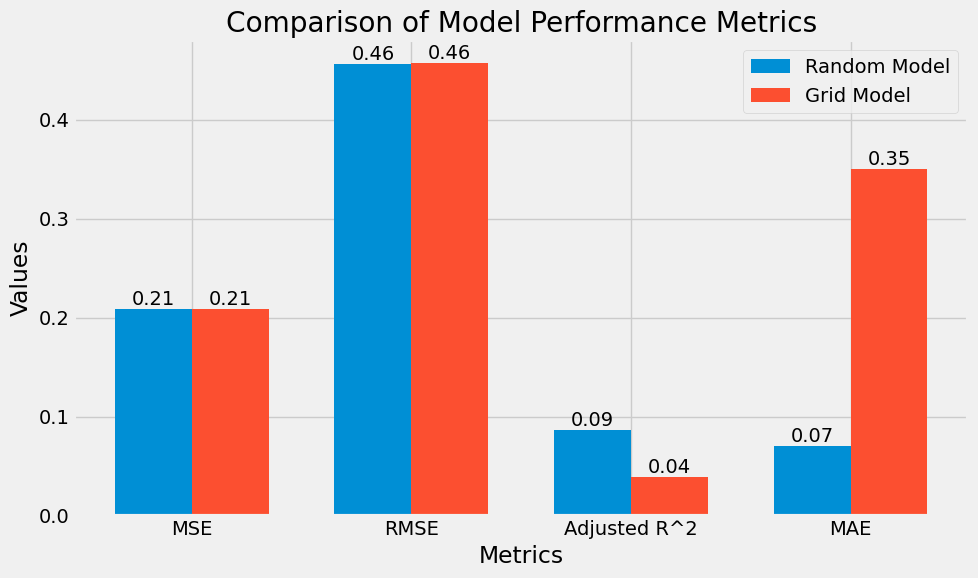

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Replace these placeholders with actual values
metrics = ['MSE', 'RMSE', 'Adjusted R^2', 'MAE']
random_model_metrics = [mse_rand, rmse_rand, adjusted_r2score_rand, mae_rand]  # Placeholder
grid_model_metrics = [mse, math.sqrt(mse), adjusted_r2score, mae]  # Placeholder

# X-axis positions for each bar group
x = np.arange(len(metrics))

# Bar width
bar_width = 0.35

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - bar_width/2, random_model_metrics, bar_width, label='Random Model')
bars2 = ax.bar(x + bar_width/2, grid_model_metrics, bar_width, label='Grid Model')

# Add labels and titles
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Annotate bars with their values
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

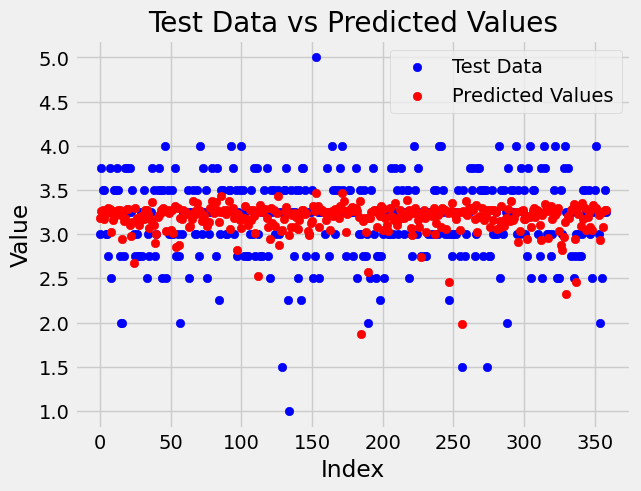

In [19]:
plt.scatter(range(len(y_test)), y_test, color='blue', label='Test Data')  # Actual test data
plt.scatter(range(len(y_pred)), y_pred_rand, color='red', label='Predicted Values')  # Predicted values

# Add labels and legend
plt.title('Test Data vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

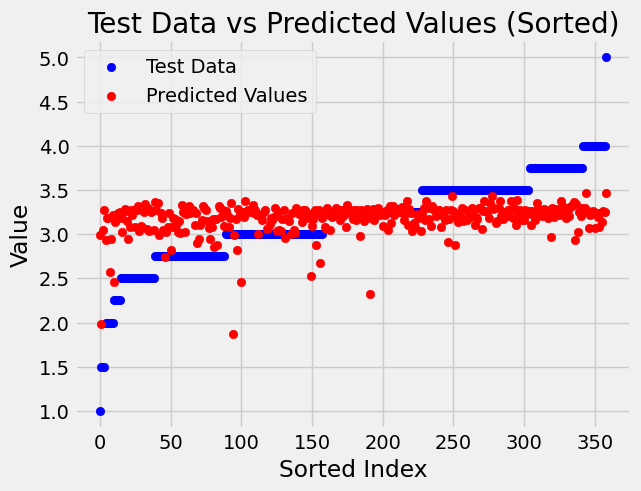

In [20]:
sorted_indices = np.argsort(y_test)  # Indices to sort y_test
y_test_sorted = np.array(y_test)[sorted_indices]  # Sorted y_test
y_pred_sorted = np.array(y_pred_rand)[sorted_indices]  # Align y_pred with sorted y_test

# Create a scatter plot
plt.scatter(range(len(y_test_sorted)), y_test_sorted, color='blue', label='Test Data')  # Sorted actual values
plt.scatter(range(len(y_pred_sorted)), y_pred_sorted, color='red', label='Predicted Values')  # Sorted predictions

# Add labels and legend
plt.title('Test Data vs Predicted Values (Sorted)')
plt.xlabel('Sorted Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()